

<a href="https://colab.research.google.com/drive/1lUYmtcybD_Ie_peZ_8ZiY-m4HqNlqpth?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Todolist
- Gunakan Model yang Lebih Maju untuk menjawab pertanyaan seputar finansial menggunakan bahasa indonesia
- Membersihkan teks dari tanda baca yang tidak perlu atau melakukan tokenisasi yang lebih tepat
- Penyaringan atau pemrosesan lanjutan untuk memastikan bahwa jawaban yang dihasilkan relevan dan bermakna
- Perluas dataset pelatihan dengan pertanyaan yang lebih bervariasi dan relevan sehingga model memiliki lebih banyak informasi untuk merespons pertanyaan yang mungkin tidak ada dalam dataset

## Install package

In [1]:
# %pip install tensorflow pandas transformers datasets

## Import package

In [2]:
import pandas as pd
from datasets import Dataset
from transformers import TFBertForQuestionAnswering, BertTokenizerFast, DefaultDataCollator, create_optimizer
from transformers import TrainingArguments, Trainer
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
import numpy as np

In [3]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress most TensorFlow messages
tf.get_logger().setLevel('ERROR')

In [4]:
# Ensure tf_keras is installed
try:
    import tf_keras
except ImportError:
    print("tf-keras is not installed. Installing now...")
    %pip install tf-keras

# Load the dataset

In [5]:
# Load the dataset
df = pd.read_csv('../data/final_dataset.csv')
dataset = Dataset.from_pandas(df)
df.head()

,id,context,question,answer,answer_start
0,1,ROI atau Return on Investment adalah rasio keu...,Apa itu ROI?,ROI atau Return on Investment adalah rasio keu...,0
1,2,"EBITDA atau Earnings Before Interest, Taxes, D...",Apa itu EBITDA?,"EBITDA atau Earnings Before Interest, Taxes, D...",0
2,3,Leverage dalam konteks finansial adalah penggu...,Apa itu Leverage?,Leverage dalam konteks finansial adalah penggu...,0
3,4,Diversifikasi adalah strategi investasi yang m...,Apa itu Diversifikasi?,Diversifikasi adalah strategi investasi yang m...,0
4,5,Volatilitas adalah ukuran seberapa besar harga...,Apa itu Volatilitas?,Volatilitas adalah ukuran seberapa besar harga...,0


In [6]:
print(df.columns)

Index(['id', 'context', 'question', 'answer', 'answer_start'], dtype='object')


# Load the tokenizer and model for fine-tuning

In [7]:
# Load the tokenizer and model for fine-tuning
model_name = "Rifky/Indobert-QA"
tokenizer = BertTokenizerFast.from_pretrained(model_name)
model = TFBertForQuestionAnswering.from_pretrained(model_name)

c:\Users\alifs\anaconda3\envs\main-ds\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertForQuestionAnswering: ['bert.embeddings.position_ids']
- This IS expected if you are initializing TFBertForQuestionAnswering from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertForQuestionAnswering from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertForQuestionAnswering were initialized from the PyTorch 

# Preprocess the dataset

In [8]:
# Preprocess the dataset
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["context"],
        max_length=384,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )
    offset_mapping = inputs.pop("offset_mapping")
    answers = examples["answer"]
    start_positions = []
    end_positions = []

    for i, (answer, offset) in enumerate(zip(answers, offset_mapping)):
        start_char = examples["answer_start"][i]
        end_char = start_char + len(answer)

        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        if offset[context_start][0] > end_char or offset[context_end][1] < start_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            start_idx = context_start
            while start_idx <= context_end and offset[start_idx][0] <= start_char:
                start_idx += 1
            start_positions.append(start_idx - 1)

            end_idx = context_start
            while end_idx <= context_end and offset[end_idx][1] < end_char:
                end_idx += 1
            end_positions.append(end_idx - 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [9]:
tokenized_datasets = dataset.map(preprocess_function, batched=True)
print(tokenized_datasets)

Map:   0%|          | 0/927 [00:00<?, ? examples/s]

Dataset({
    features: ['id', 'context', 'question', 'answer', 'answer_start', 'input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 927
})


In [10]:
# Check the first few elements
for item in tokenized_datasets:
    print(item)
    break

{'id': 1, 'context': 'ROI atau Return on Investment adalah rasio keuntungan atau kerugian yang dihasilkan dari investasi relatif terhadap biaya investasi. ROI sering digunakan untuk mengevaluasi efisiensi atau profitabilitas suatu investasi atau untuk membandingkan efisiensi beberapa investasi yang berbeda.', 'question': 'Apa itu ROI?', 'answer': 'ROI atau Return on Investment adalah rasio keuntungan atau kerugian yang dihasilkan dari investasi relatif terhadap biaya investasi.', 'answer_start': 0, 'input_ids': [3, 2064, 1570, 3057, 939, 35, 4, 3057, 939, 1647, 22739, 2587, 23270, 1581, 10357, 4994, 1647, 5938, 1497, 6023, 1542, 5737, 5646, 1973, 3592, 5737, 18, 3057, 939, 2633, 2318, 1559, 16029, 11311, 1647, 17479, 13163, 2170, 5737, 1647, 1559, 13622, 11311, 1841, 5737, 1497, 2748, 18, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

# Split dataset into train and validation

In [11]:
train_test_split = tokenized_datasets.train_test_split(test_size=0.01)
train_dataset = train_test_split['train']
eval_dataset = train_test_split['test']
print(train_dataset)
print(eval_dataset)

Dataset({
    features: ['id', 'context', 'question', 'answer', 'answer_start', 'input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 917
})
Dataset({
    features: ['id', 'context', 'question', 'answer', 'answer_start', 'input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions'],
    num_rows: 10
})


In [12]:
for i in range(eval_dataset.num_rows):  # Adjust the range to view more samples
    print(eval_dataset[i])

{'id': 869, 'context': 'Pasar finansial adalah tempat di mana instrumen keuangan seperti saham, obligasi, mata uang, dan komoditas diperdagangkan. Pasar ini mencakup pasar modal, pasar uang, dan pasar derivatif. Pasar finansial menyediakan platform bagi investor untuk membeli dan menjual aset, serta bagi perusahaan untuk mengumpulkan dana. Fungsi utama pasar finansial adalah memfasilitasi alokasi modal secara efisien dan mendukung likuiditas ekonomi. Pasar yang efisien dan transparan penting untuk stabilitas ekonomi dan pertumbuhan yang berkelanjutan.', 'question': 'Apa itu pasar finansial dan fungsinya?', 'answer': 'Pasar finansial adalah tempat di mana instrumen keuangan seperti saham, obligasi, mata uang, dan komoditas diperdagangkan', 'answer_start': 0, 'input_ids': [3, 2064, 1570, 2820, 10122, 1501, 12934, 35, 4, 2820, 10122, 1581, 1991, 1485, 2420, 9571, 3842, 1730, 3955, 16, 12253, 16, 2704, 2755, 16, 1501, 10828, 18453, 18, 2820, 1540, 5408, 2820, 4830, 16, 2820, 2755, 16, 1501

# Define training arguments

In [13]:
# Define training arguments
training_args = TrainingArguments(
    output_dir="../models/fine_tuned_model",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='../logs',
    logging_steps=10,
    max_steps=1000,
)

In [14]:
# Create a data collator
data_collator = DefaultDataCollator(return_tensors="tf")

# Convert datasets to tf.data.Dataset

In [15]:
# Convert datasets to tf.data.Dataset
tf_train_dataset = train_dataset.shuffle(seed=42).to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    batch_size=8,
    collate_fn=data_collator,
    shuffle=True,
)
tf_eval_dataset = eval_dataset.to_tf_dataset(
    columns=['input_ids', 'attention_mask', 'start_positions', 'end_positions'],
    batch_size=8,
    collate_fn=data_collator,
    shuffle=False,
)

In [16]:
for batch in tf_train_dataset.take(1):
    print(batch)

{'input_ids': <tf.Tensor: shape=(8, 384), dtype=int64, numpy=
array([[   3, 2064, 1570, ...,    0,    0,    0],
       [   3, 2064, 1570, ...,    0,    0,    0],
       [   3, 2064, 1570, ...,    0,    0,    0],
       ...,
       [   3, 2064, 1497, ...,    0,    0,    0],
       [   3, 2064, 1570, ...,    0,    0,    0],
       [   3, 2064, 1570, ...,    0,    0,    0]], dtype=int64)>, 'attention_mask': <tf.Tensor: shape=(8, 384), dtype=int64, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int64)>, 'start_positions': <tf.Tensor: shape=(8,), dtype=int64, numpy=array([ 8,  7, 11, 15,  9, 11,  9,  7], dtype=int64)>, 'end_positions': <tf.Tensor: shape=(8,), dtype=int64, numpy=array([29, 23, 19, 59, 28, 22, 41, 20], dtype=int64)>}


In [17]:
num_train_steps = len(tf_train_dataset) * training_args.num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=training_args.learning_rate,
    num_warmup_steps=0,
    num_train_steps=num_train_steps,
    weight_decay_rate=training_args.weight_decay,
)

# Custom accuracy metrics for start and end logits

In [19]:
# Custom accuracy metrics for start and end logits
def start_logits_accuracy(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1)), tf.float32))

def end_logits_accuracy(y_true, y_pred):
    return tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y_true, axis=-1), tf.argmax(y_pred, axis=-1)), tf.float32))


In [20]:
model.compile(optimizer=optimizer, metrics=[start_logits_accuracy, end_logits_accuracy])

# Custom callback to log loss and accuracy

In [22]:
# Custom callback to log loss and accuracy
class LossAccuracyLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(LossAccuracyLogger, self).__init__()
        self.epoch_loss = []
        self.val_loss = []
        self.start_logits_accuracy = []
        self.end_logits_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_loss.append(logs['loss'])
        self.val_loss.append(logs['val_loss'])
        self.start_logits_accuracy.append(logs.get('start_logits_accuracy'))
        self.end_logits_accuracy.append(logs.get('end_logits_accuracy'))
        print(f"Epoch {epoch + 1} - Loss: {logs['loss']}, Val Loss: {logs['val_loss']}, Start Logits Accuracy: {logs.get('start_logits_accuracy')}, End Logits Accuracy: {logs.get('end_logits_accuracy')}")
        print(f"Logged data so far: Loss: {self.epoch_loss}, Val Loss: {self.val_loss}, Start Logits Accuracy: {self.start_logits_accuracy}, End Logits Accuracy: {self.end_logits_accuracy}")

    def plot(self):
        epochs = range(1, len(self.epoch_loss) + 1)
        plt.figure(figsize=(18, 6))
        
        # plt.subplot(1, 3, 1)
        plt.plot(epochs, self.epoch_loss, label='Training Loss')
        plt.plot(epochs, self.val_loss, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        
        # plt.subplot(1, 3, 2)
        # plt.plot(epochs, self.start_logits_accuracy, label='Start Logits Accuracy')
        # plt.xlabel('Epoch')
        # plt.ylabel('Start Logits Accuracy')
        # plt.legend()
        
        # plt.subplot(1, 3, 3)
        # plt.plot(epochs, self.end_logits_accuracy, label='End Logits Accuracy')
        # plt.xlabel('Epoch')
        # plt.ylabel('End Logits Accuracy')
        # plt.legend()
        
        plt.show()

In [23]:
logger = LossAccuracyLogger()

In [24]:
# Custom callback to log F1 score
class MetricsLogger(tf.keras.callbacks.Callback):
    def __init__(self, eval_dataset):
        super(MetricsLogger, self).__init__()
        self.epoch_f1 = []
        self.eval_dataset = eval_dataset

    def on_epoch_end(self, epoch, logs=None):
        y_true_start, y_true_end = [], []
        y_pred_start, y_pred_end = [], []

        for batch in self.eval_dataset:
            inputs = {k: v for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
            labels = {k: v for k, v in batch.items() if k in ['start_positions', 'end_positions']}
            start_true = labels['start_positions'].numpy()
            end_true = labels['end_positions'].numpy()
            outputs = self.model.predict(inputs)
            start_pred = np.argmax(outputs['start_logits'], axis=-1)
            end_pred = np.argmax(outputs['end_logits'], axis=-1)

            y_true_start.extend(start_true)
            y_true_end.extend(end_true)
            y_pred_start.extend(start_pred)
            y_pred_end.extend(end_pred)

        start_f1 = f1_score(y_true_start, y_pred_start, average='micro')
        end_f1 = f1_score(y_true_end, y_pred_end, average='micro')
        overall_f1 = (start_f1 + end_f1) / 2
        self.epoch_f1.append(overall_f1)
        print(f"Epoch {epoch + 1} - F1 Score: {overall_f1}")
        print(f"Logged F1 data so far: {self.epoch_f1}")

    def plot(self):
        epochs = range(1, len(self.epoch_f1) + 1)
        plt.figure(figsize=(12, 5))
        plt.plot(epochs, self.epoch_f1, label='F1 Score')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.legend()
        plt.show()

In [25]:
# Instantiate the callback
metrics_logger = MetricsLogger(tf_eval_dataset)

# Train the model

In [26]:
# Train the model
history = model.fit(tf_train_dataset, epochs=training_args.num_train_epochs, callbacks=[logger, metrics_logger], validation_data=tf_eval_dataset)

Epoch 1/3
Cause: for/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
115/115 [==============================] - ETA: 0s - loss: 1.3200 - end_logits_start_logits_accuracy: 0.0000e+00 - end_logits_end_logits_accuracy: 0.0000e+00 - start_logits_start_logits_accuracy: 0.0000e+00 - start_logits_end_logits_accuracy: 0.0000e+00Epoch 1 - Loss: 1.3199982643127441, Val Loss: 1.0616300106048584, Start Logits Accuracy: None, End Logits Accuracy: None
Logged data so far: Loss: [1.3199982643127441], Val Loss: [1.0616300106048584], Start Logits Accuracy: [None], End Logits Accuracy: [None]
1/1 [==============================] - 1s 520ms/step
Epoch 1 - F1 Score: 0.8
Logged F1 data so far: [0.8]
115/115 [==============================] - 1173s 10s/step - loss: 1.3200 - end_logits_start_logits_accuracy: 0.0000e+00 - end_logits_end_logits_accuracy: 0.0000e+00 - start_logits_start_logits_accuracy: 0.0000e+00 - start_logits_end_

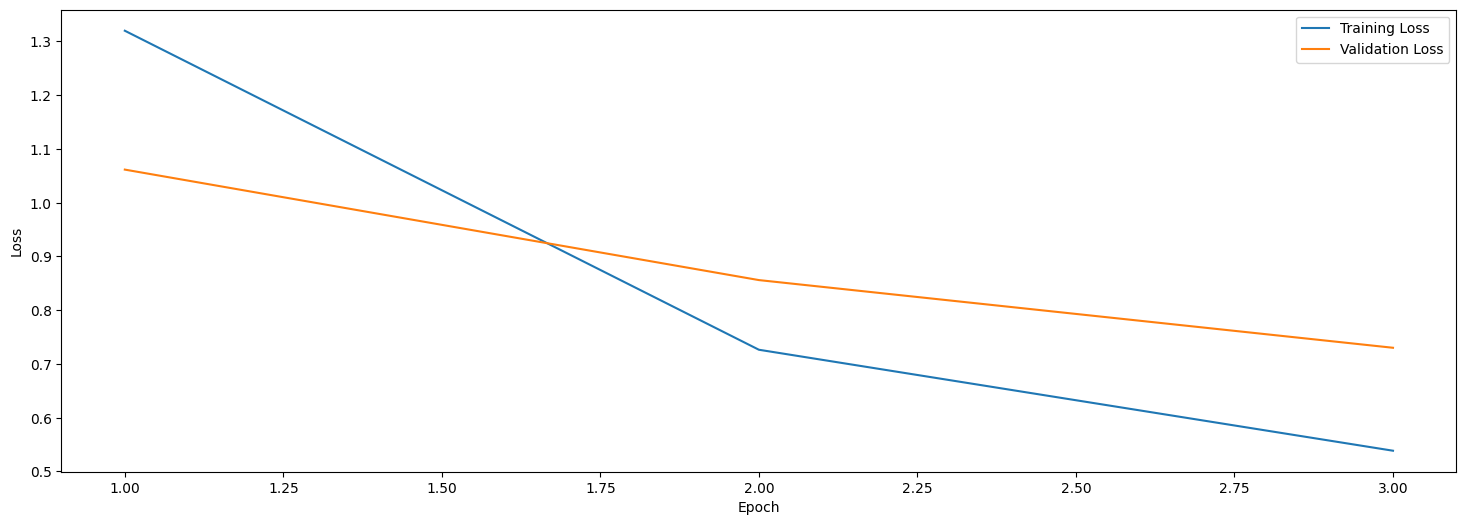

In [27]:
logger.plot()

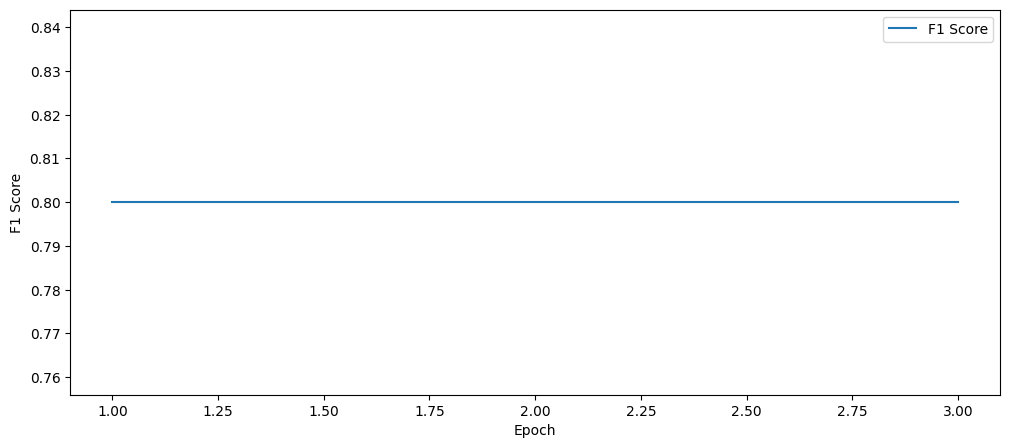

In [28]:
metrics_logger.plot()

# Tabel log

In [29]:
# Buat dictionary kosong untuk menampung statistik pelatihan
training_stats = {
    'epoch': list(range(1, training_args.num_train_epochs + 1)),
    'loss': history.history['loss'],  # Gunakan loss dari history
    'val_loss': history.history['val_loss']  # Gunakan val_loss dari history
}

# Ambil metrik dari logger jika tersedia
if logger.start_logits_accuracy and logger.end_logits_accuracy:
    training_stats['start_logits_accuracy'] = logger.start_logits_accuracy
    training_stats['end_logits_accuracy'] = logger.end_logits_accuracy

# Ambil F1 score dari metrics logger jika tersedia
if metrics_logger.epoch_f1:
    training_stats['f1_score'] = metrics_logger.epoch_f1

# Buat DataFrame dari dictionary
df_stats = pd.DataFrame(training_stats)

# Setel indeks DataFrame menjadi kolom 'epoch'
df_stats = df_stats.set_index('epoch')

# Setel opsi untuk menampilkan presisi desimal
pd.set_option('display.precision', 2)

# Hapus baris dengan nilai None
df_stats = df_stats.dropna(axis=1, how='all')
# pd.set_option('display.precision', 2)

print(df_stats)


       loss  val_loss  f1_score
epoch                          
1      1.32      1.06       0.8
2      0.73      0.86       0.8
3      0.54      0.73       0.8


# Handler Out of Context

In [30]:
def provide_recommendation():
    recommendation = ("Terima kasih atas pertanyaannya. Saya ingin menjelaskan bahwa peran saya di sini adalah untuk "
                      "memberikan panduan dan rekomendasi seputar isu keuangan. Meskipun saya tidak memberikan jawaban "
                      "yang langsung terkait dengan pertanyaan Anda, saya berharap rekomendasi berikut dapat membantu Anda "
                      "mengelola keuangan Anda dengan lebih baik:\n\n"
                      
                      "1. Pertama-tama, langkah yang paling penting adalah membangun anggaran yang terperinci dan "
                      "memantau pengeluaran Anda secara cermat. Dengan demikian, Anda dapat mengidentifikasi area di mana Anda "
                      "dapat menghemat dan mengalokasikan dana dengan lebih efisien.\n\n"
                      
                      "2. Selain mengelola pengeluaran, pertimbangkan untuk mencari peluang pendapatan tambahan melalui "
                      "pekerjaan sampingan atau proyek-proyek paruh waktu. Hal ini dapat membantu meningkatkan pendapatan Anda "
                      "dan memperluas sumber pendapatan.\n\n"
                      
                      "3. Selanjutnya, luangkan waktu untuk mempelajari opsi investasi yang tersedia dan alokasikan dana Anda "
                      "dengan bijak. Mungkin Anda ingin mempertimbangkan investasi dalam instrumen keuangan seperti saham, "
                      "obligasi, atau properti. Namun, pastikan untuk melakukan riset yang teliti dan berkonsultasi dengan "
                      "profesional keuangan jika diperlukan.\n\n"
                      
                      "4. Selain itu, penting untuk terus mengembangkan keterampilan yang bernilai tinggi dalam karier Anda. "
                      "Pertimbangkan untuk memonetisasi hobi atau minat Anda sebagai sumber pendapatan tambahan. Hal ini dapat "
                      "membantu meningkatkan potensi penghasilan Anda di masa mendatang.\n\n"
                      
                      "5. Terakhir, namun tidak kalah pentingnya, pastikan Anda memiliki perencanaan keuangan jangka panjang "
                      "yang solid. Ini termasuk perencanaan pensiun yang baik serta perlindungan asuransi untuk melindungi Anda "
                      "dari risiko finansial yang tidak terduga.\n\n"
                      
                      "Semoga rekomendasi ini memberikan arahan yang berguna bagi Anda dalam memulai atau meningkatkan "
                      "perjalanan keuangan Anda. Jika Anda memiliki pertanyaan lebih lanjut atau membutuhkan bantuan tambahan, "
                      "jangan ragu untuk bertanya. Saya siap membantu Anda dalam segala hal terkait keuangan Anda.")
    
    return recommendation


In [31]:
def answer_question(question, context):
    if context is None:
        return provide_recommendation()  # Return recommendation if context not found

    inputs = tokenizer(question, context, return_tensors="tf", max_length=384, truncation=True, padding=True)

    outputs = model(inputs)

    # Get the start and end positions of the answer
    answer_start = tf.argmax(outputs.start_logits, axis=1).numpy()[0]
    answer_end = tf.argmax(outputs.end_logits, axis=1).numpy()[0]

    # Ensure the answer_end is greater than or equal to answer_start
    if answer_end < answer_start:
        answer_end = answer_start

    # Extract the answer tokens, extending to a reasonable length if necessary
    max_answer_length = 100
    answer_tokens = inputs["input_ids"][0][answer_start:answer_end + max_answer_length]

    # Convert tokens to text, skipping special tokens
    answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)

    # Strip out any trailing special tokens (like [SEP])
    answer = answer.split("[SEP]")[0]

    return answer


In [32]:
# Function to find context based on the question using Jaccard similarity
def find_context_for_question(question, dataframe):
    max_matched_words = 0
    best_matched_context = None
    context_found = False

    # Iterate through the rows of the dataframe
    for _, row in dataframe.iterrows():
        if question.strip().lower() in row['question'].strip().lower():
            best_matched_context = row['context']
            context_found = True
            break  # Break the loop if a matching context is found

    # If no exact match is found, find the best matching context based on the number of common words
    if not context_found:
        for _, row in dataframe.iterrows():
            dataset_tokens = set(row['question'].strip().lower().split())
            matched_words = len(set(question.strip().lower().split()).intersection(dataset_tokens))
            if matched_words > max_matched_words:
                max_matched_words = matched_words
                best_matched_context = row['context']

    return best_matched_context, context_found

# Test Model

In [33]:
# User input for the question
# user_question = input("Enter your financial question: ")
# user_question = "Apa itu EBITDA"
# user_question = "Apa pentingnya membuat anggaran dalam mengelola uang dalam negeri"
user_question = "apa itu cuaca"

In [34]:
# Find context for the user's question
# context = find_context_for_question(user_question, df)
context, context_found = find_context_for_question(user_question, df)

In [35]:
# Function to find context based on the question
# Mendekati dataset
# Tidak disarankan karena halusinasi

def provide_recommendation_for_question(question):
    # Define the common words to ignore
    common_words = {
        "apa", "kenapa", "mengapa", "apa itu", "bagaimana", "siapa",
        "di mana", "kapan", "yang", "adalah", "untuk", "dengan",
        "ke", "dari", "atau", "dan", "jika", "jika", "maka",
        "seperti", "oleh", "agar", "sehingga", "karena", "namun",
        "jadi", "tidak", "adalah", "bahwa", "itu", "dalam",
        "oleh", "pada", "untuk", "dengan", "tanpa", "saat",
        "akan", "sudah", "belum", "pernah", "apakah", "apabila",
        "bagaimanakah", "sebagaimana", "adakah", "bilamana", "mengapakah",
        "kapankah", "dimanakah", "siapakah", "apa sajakah", "berapa"
    }

    # Function to filter out common words from a list of tokens
    def filter_common_words(tokens):
        return [word for word in tokens if word not in common_words]

    max_matched_words = 0
    best_matched_context = None

    # Tokenize and filter the question
    question_tokens = set(filter_common_words(question.strip().lower().split()))

    # Iterate through the rows of the dataset
    for _, row in df.iterrows():
        dataset_tokens = set(filter_common_words(row['question'].strip().lower().split()))
        matched_words = len(question_tokens.intersection(dataset_tokens))
        if matched_words > max_matched_words:
            max_matched_words = matched_words
            best_matched_context = row['context']

    if best_matched_context:
        return best_matched_context
    else:
        return provide_recommendation()


In [36]:
if context_found:
    # Get the answer to the user question using the found context
    answer = answer_question(user_question, context)
    print(f"Q: {user_question}\nA: {answer}")
else:
    # If context is not found, provide a recommendation based on the user's question
    answer = provide_recommendation_for_question(user_question)
    print(f"Q: {user_question}\nA: {answer}")

Q: apa itu cuaca
A: Terima kasih atas pertanyaannya. Saya ingin menjelaskan bahwa peran saya di sini adalah untuk memberikan panduan dan rekomendasi seputar isu keuangan. Meskipun saya tidak memberikan jawaban yang langsung terkait dengan pertanyaan Anda, saya berharap rekomendasi berikut dapat membantu Anda mengelola keuangan Anda dengan lebih baik:

1. Pertama-tama, langkah yang paling penting adalah membangun anggaran yang terperinci dan memantau pengeluaran Anda secara cermat. Dengan demikian, Anda dapat mengidentifikasi area di mana Anda dapat menghemat dan mengalokasikan dana dengan lebih efisien.

2. Selain mengelola pengeluaran, pertimbangkan untuk mencari peluang pendapatan tambahan melalui pekerjaan sampingan atau proyek-proyek paruh waktu. Hal ini dapat membantu meningkatkan pendapatan Anda dan memperluas sumber pendapatan.

3. Selanjutnya, luangkan waktu untuk mempelajari opsi investasi yang tersedia dan alokasikan dana Anda dengan bijak. Mungkin Anda ingin mempertimbangkan

## Embadding

In [229]:
# from sentence_transformers import SentenceTransformer, util

# # Load pre-trained sentence transformer for generating embeddings
# sentence_model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

# # Generate embeddings for all questions in the dataset
# df['question_embedding'] = df['question'].apply(lambda x: sentence_model.encode(x, convert_to_tensor=True))

# def find_context_for_question(question, dataframe):
#     question_embedding = sentence_model.encode(question, convert_to_tensor=True)
#     best_matched_context = None
#     max_similarity = -1

#     for _, row in dataframe.iterrows():
#         similarity = util.pytorch_cos_sim(question_embedding, row['question_embedding'])[0][0].item()
#         if similarity > max_similarity:
#             max_similarity = similarity
#             best_matched_context = row['context']

#     return best_matched_context

# user_question = "Apa itu pendapatan pasif"
# context = find_context_for_question(user_question, df)

# if context:
#     answer = answer_question(user_question, context)
#     print(f"Q: {user_question}\nA: {answer}")
# else:
#     print(f"Q: {user_question}\nA: {provide_recommendation()}")


# Save model

In [265]:
# Save the model at the end
# model.save_pretrained("../models/gen-ai/fine_tuned_model")
# tokenizer.save_pretrained("../models/gen-ai/fine_tuned_model")

In [38]:
# Save the model in TensorFlow SavedModel format
model.save('../models/gen-ai/my_model', save_format='tf')

# Save the model weights only (optional)
model.save_weights('../models/gen-ai/my_model_weights.h5')
